# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# подключение необходимых библиотек
import os
import math
import time
import itertools 
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
from pathlib import Path
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# откроем файл
df = pd.read_csv('/datasets/autos.csv')

In [3]:
# посмотрим общую информацию методом info и describe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
# посмотрим количкство пропущенных значений
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        return mz_table

missing_zero_values_table(df)

,Zero Values,Missing Values,% of Total Values,Data Type
NotRepaired,0,71154,20.1,object
VehicleType,0,37490,10.6,object
FuelType,0,32895,9.3,object
Gearbox,0,19833,5.6,object
Model,0,19705,5.6,object


In [6]:
# посмотрим количество дубликатов
df.duplicated().sum()

4

In [7]:
# удалим стоблцы, которые нам не понадобятся
df=df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [8]:
# поменяем порядок столбцов для удобного чтения
column_names = ['Brand','Model','VehicleType','RegistrationYear','Gearbox','Power','FuelType','Kilometer','NotRepaired','RegistrationMonth','Price']
df = df.reindex(columns=column_names)

### Подготовка категориальных данных

In [9]:
# заменим на 1 и 0, значения yes и no
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})

In [10]:
# посмотрим сколько уникальных значений мы имеем в categorical признаках
categorical = ['Brand','Model','VehicleType','Gearbox','FuelType']
numerical_features_names = df.select_dtypes(include=['int64'])
df[categorical].nunique()

Brand           40
Model          250
VehicleType      8
Gearbox          2
FuelType         7
dtype: int64

2700.0

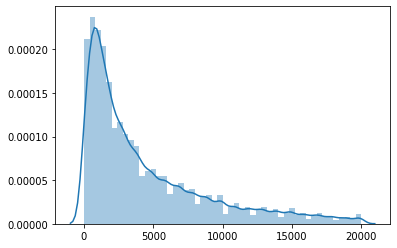

In [11]:
# посмотрим на распределение целевого признака
sns.distplot(df.Price.values)
np.median(df.Price.values)

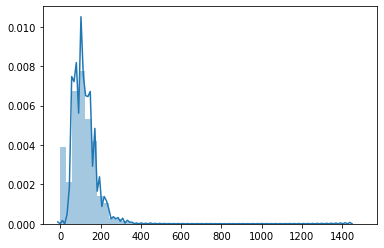

In [12]:
sns.distplot(df.Power.values, kde_kws={"clip":(0,1500)}, hist_kws={"range":(0,1500)})

In [13]:
df = df[df['Power']<=1300]

In [14]:
# пустые значения в NotRepaired заменим на 0, так как скорее всего пользователи заполнявшие форму "Чинилась ли машина", просто не заполняли, если не чинилась. Будем считать так...
df['NotRepaired'] = df['NotRepaired'].fillna(0)
df['NotRepaired'] = df['NotRepaired'].astype('int64')

In [15]:
def fill_with_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [16]:
# на основе имеющихся данных попробуем заменить пустые значения
fill_with_mode('Model','Brand','RegistrationYear')
fill_with_mode('VehicleType','Brand','Model')
fill_with_mode('FuelType','Brand','Model')

In [17]:
# заменим Empty на nan
df = df.replace('Empty',np.nan)

missing_zero_values_table(df) 

,Zero Values,Missing Values,% of Total Values,Data Type
Gearbox,0,19819,5.6,object
Model,0,3439,1.0,object
VehicleType,0,24,0.0,object
FuelType,0,12,0.0,object


In [18]:
# удалим nan Значения и дубликаты
df = df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301749 entries, 0 to 354368
Data columns (total 11 columns):
Brand                301749 non-null object
Model                301749 non-null object
VehicleType          301749 non-null object
RegistrationYear     301749 non-null int64
Gearbox              301749 non-null object
Power                301749 non-null int64
FuelType             301749 non-null object
Kilometer            301749 non-null int64
NotRepaired          301749 non-null int64
RegistrationMonth    301749 non-null int64
Price                301749 non-null int64
dtypes: int64(6), object(5)
memory usage: 27.6+ MB


In [19]:
df.head()

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,RegistrationMonth,Price
0,volkswagen,golf,sedan,1993,manual,0,petrol,150000,0,0,480
1,audi,a4,coupe,2011,manual,190,gasoline,125000,1,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,0,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,0,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,0,7,3600


In [20]:
# скопируем датафрейм для моделей catboost и lightgbm без перевода категориальных данных в номинальные, так как обе модели
# поддерживают работу с категориальными данными

df_with_categorical_features = df.copy()
df_with_categorical_features

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,RegistrationMonth,Price
0,volkswagen,golf,sedan,1993,manual,0,petrol,150000,0,0,480
1,audi,a4,coupe,2011,manual,190,gasoline,125000,1,5,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,0,8,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,0,6,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,0,7,3600
...,...,...,...,...,...,...,...,...,...,...,...
354362,seat,leon,sedan,2004,manual,225,petrol,150000,1,5,3200
354364,mitsubishi,colt,sedan,2005,manual,0,petrol,150000,1,7,0
354366,smart,fortwo,convertible,2000,auto,101,petrol,125000,0,3,1199
354367,volkswagen,transporter,bus,1996,manual,102,gasoline,150000,0,3,9200


In [21]:
# приведем категориальные признаки в номинальные с помощью LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
columns_for_convert = list(df.select_dtypes(include='object').columns)
for column in columns_for_convert:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))

In [22]:
df.head()

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,RegistrationMonth,Price
0,37,116,4,1993,1,0,6,150000,0,0,480
1,1,29,2,2011,1,190,2,125000,1,5,18300
2,14,117,6,2004,0,163,2,125000,0,8,9800
3,37,116,5,2001,1,75,6,150000,0,6,1500
4,31,101,5,2008,1,69,2,90000,0,7,3600


### Подготовка количественных данных 

#### Power

In [24]:
sum(df['Power']==0)

24967

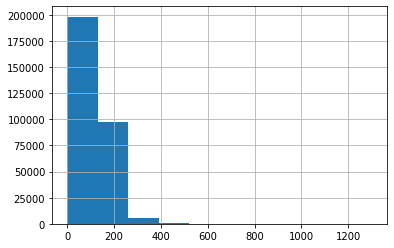

In [25]:
df['Power'].hist()

In [26]:
print(df['Power'].mean())
print(df['Power'].median())

110.81078644833951
105.0


Заменим нулевые значения на среднее, так как медиана и среднее почти совпали

In [27]:
df.loc[df['Power']==0, 'Power'] = df['Power'].mean()

#### Price

In [28]:
sum(df['Price']==0)

7164

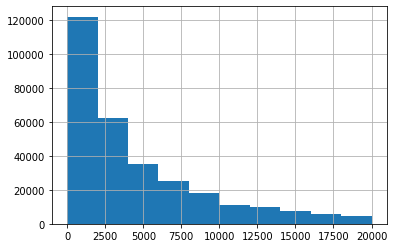

In [29]:
df['Price'].hist()

In [30]:
print(df['Price'].mean())
print(df['Price'].median())

4526.974770421774
2800.0


В данном случае следует заменяем нулевые значения на медиану

In [31]:
df.loc[df['Price']==0, 'Price'] = df['Price'].median()

### Registration year

In [32]:
sum(df['RegistrationYear']==1000)

2

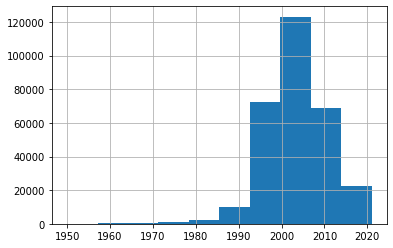

In [33]:
df['RegistrationYear'].hist(range=[1950,2021])

In [34]:
print(df['RegistrationYear'].mean())
print(df['RegistrationYear'].median())

2003.3916533277659
2003.0


In [35]:
df.loc[df['RegistrationYear']==1000, 'RegistrationYear'] = df['RegistrationYear'].mean()

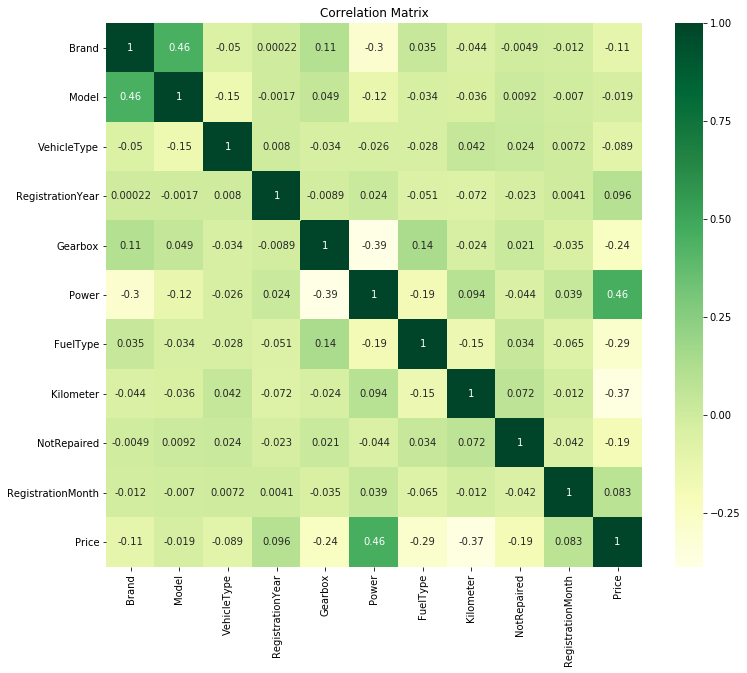

In [36]:

plt.figure(figsize=(12,10))
plt.title("Correlation Matrix")
sns.heatmap(df.corr(), cmap="YlGn", annot=True)


**Вывод:**
- Провели срез в признаке Power до 1300 лошадинных сил, так как я считаю что больше чем 1300 лс не бывает
- Заменили пустые значения в столбцах model, brand, на имеющиеся значения с похожими значениями.
- Удалили дубликаты и пустые значения (подготовили датасет)
- Перевели категориальные данные в номинальные с помощью LabelEncoder
- Провели стандартизацию

## Обучение моделей

- Изучим две модели Градиентного бустинга : CatBoost, LightGBM и Линейную регрессию
- Проверим все три модели на дефолтных параметрах без какого-либо тюнинга модели и посмотрим какие результаты они нам покажут.
- Сохраним все результаты для дальнейшего анализа

In [37]:
def fill_with_mode(column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))
        
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

In [38]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

print('Train size:', X_train.shape[0])
print(' Test size:', X_test.shape[0])

Train size: 211224
 Test size: 90525


In [39]:
# масштабирование трейн и тест раздельно
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Kilometer']
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])

In [40]:
scaler = StandardScaler()
scaler.fit(X_test[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [41]:
X_train.head()

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,RegistrationMonth
302345,1,29,7,-0.045425,1,0.202518,2,0.5734,0,5
244385,10,128,5,0.019271,1,-1.106269,6,0.5734,0,9
150761,37,170,7,-0.142469,1,-0.073987,2,0.5734,0,8
69173,34,166,6,-0.336557,1,-0.737597,6,0.5734,0,4
41187,0,3,7,-0.077773,1,0.552757,6,0.5734,0,5


In [42]:
X_test.head()

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,RegistrationMonth
39848,20,33,4,0.203007,1,-0.703205,2,-1.318064,0,11
261067,27,227,5,-0.122349,1,-1.148513,6,0.577571,0,5
115130,23,174,4,-0.158499,1,0.187413,6,0.577571,0,2
24628,24,83,5,-0.266951,1,-1.389722,6,0.577571,1,6
224412,37,224,0,-0.194650,1,-0.276450,2,0.577571,0,3


In [43]:
df_with_categorical_features[categorical] = df_with_categorical_features[categorical].astype('category')
df_with_categorical_features['NotRepaired'] = df_with_categorical_features['NotRepaired'].astype('int64')

In [44]:
X_ = df_with_categorical_features.drop(['Price'],axis=1)
y_ = df_with_categorical_features['Price']

X__train, X__test, y__train, y__test = train_test_split(X_, y_, test_size=0.3, random_state=17)
# размеры обучающей и тестовой выборки
print('Размер обучающей выборки с категориальными данными: {} объектов, {} признаков'.format(X__train.shape[0], X__train.shape[1]))
print('Размер тестовой выборки с категориальными данными: {} объектов, {} признаков'.format(X__test.shape[0], X__test.shape[1]))

Размер обучающей выборки с категориальными данными: 211224 объектов, 10 признаков
Размер тестовой выборки с категориальными данными: 90525 объектов, 10 признаков


### **CatBoost**

In [45]:
model_cbr = CatBoostRegressor(cat_features=categorical)

In [46]:
%%time
start = time.time()
model_cbr.fit(X__train, y__train, eval_set=(X__test, y__test), verbose=200);
end = time.time()
catboost_time = end - start

0:	learn: 4463.0628120	test: 4467.6670008	best: 4467.6670008 (0)	total: 925ms	remaining: 15m 23s
200:	learn: 1927.0560321	test: 1940.4661932	best: 1940.4661932 (200)	total: 2m 12s	remaining: 8m 47s
400:	learn: 1837.7020625	test: 1856.5736306	best: 1856.5736306 (400)	total: 4m 21s	remaining: 6m 29s
600:	learn: 1793.7408590	test: 1817.9408728	best: 1817.9408728 (600)	total: 6m 31s	remaining: 4m 19s
800:	learn: 1768.6965606	test: 1797.9933738	best: 1797.9933738 (800)	total: 8m 42s	remaining: 2m 9s
999:	learn: 1748.5819404	test: 1783.5112898	best: 1783.5112898 (999)	total: 10m 54s	remaining: 0us

bestTest = 1783.51129
bestIteration = 999

CPU times: user 9min 34s, sys: 1min 21s, total: 10min 55s
Wall time: 11min


In [47]:
start = time.time()
predictions = model_cbr.predict(X__test)
end = time.time()
catboost_time_predicting = end - start
print('RMSE=',rmse(predictions,y__test))
rmse_list = []
rmse_list.append(rmse(predictions,y__test))
time_list = []
predicting_time = []
time_list.append(catboost_time)
predicting_time.append(catboost_time_predicting)

RMSE= 1783.5112897664733


### **LightGBM**

In [48]:
gbm = lgb.LGBMRegressor()

In [49]:
%%time
start = time.time()
gbm.fit(X__train, y__train, eval_set=[(X__test, y__test)], eval_metric='rmse', categorical_feature=categorical)
end = time.time()
lightgbm_time = end - start

[1]	valid_0's rmse: 4228.94	valid_0's l2: 1.78839e+07
[2]	valid_0's rmse: 3945.61	valid_0's l2: 1.55679e+07
[3]	valid_0's rmse: 3700.43	valid_0's l2: 1.36932e+07
[4]	valid_0's rmse: 3479.02	valid_0's l2: 1.21036e+07
[5]	valid_0's rmse: 3287.91	valid_0's l2: 1.08103e+07
[6]	valid_0's rmse: 3119.11	valid_0's l2: 9.72885e+06
[7]	valid_0's rmse: 2970.46	valid_0's l2: 8.82363e+06
[8]	valid_0's rmse: 2833.83	valid_0's l2: 8.0306e+06
[9]	valid_0's rmse: 2720.63	valid_0's l2: 7.40182e+06
[10]	valid_0's rmse: 2611.68	valid_0's l2: 6.82089e+06
[11]	valid_0's rmse: 2515.24	valid_0's l2: 6.32642e+06
[12]	valid_0's rmse: 2435.11	valid_0's l2: 5.92976e+06
[13]	valid_0's rmse: 2362.57	valid_0's l2: 5.58174e+06
[14]	valid_0's rmse: 2303.3	valid_0's l2: 5.30521e+06
[15]	valid_0's rmse: 2247.77	valid_0's l2: 5.05245e+06
[16]	valid_0's rmse: 2199.31	valid_0's l2: 4.83694e+06
[17]	valid_0's rmse: 2156.37	valid_0's l2: 4.64995e+06
[18]	valid_0's rmse: 2119.83	valid_0's l2: 4.49366e+06
[19]	valid_0's rmse: 

In [50]:
start = time.time()
predictions = gbm.predict(X__test,num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_predicting_time = end - start
print('RMSE = ', rmse(predictions, y__test))
rmse_list.append(rmse(predictions,y__test))
predicting_time.append(lightgbm_predicting_time)
time_list.append(lightgbm_time)

RMSE =  1749.93157185865


### **LinearRegression**

In [51]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [52]:
%%time
start = time.time()
lr.fit(X_train,y_train)
end = time.time()
linear_time = end - start

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 87.2 ms


In [57]:
start = time.time()
predictions = lr.predict(X_test)
end = time.time()
linear_time_predicting = end - start
print(rmse(predictions,y_test))
rmse_list.append(rmse(predictions,y_test))
time_list.append(linear_time)
predicting_time.append(linear_time_predicting)

3263.930837131321


**Вывод:**
- Запустили все три модели со стандартными параметрами, настройками.
- Получили такие результаты :

 - CatBoost : 1783 на тестовой выборке, время обучения : 626 сек
 - LightGBM : 1749 на тестовой выборке, время обучения : 1.4 сек
 - LinearRegression : 3325 на тестовой выборке, время обучения : 0.07 сек
- Пока можем сказать, что из коробки хорошие результаты дает LightGBM и время обучения 1.4 секунды. На втором месте CatBoost с результатом 1783 и временем: 626 сек . На последнем месте Линейная регрессия с результатом 3325 на тестовой выборке и временем : 0.07

- Посмотрим, какие результаты покажут модели, после того как мы подберем к ним наилучшие параметры

## Анализ моделей

### **CatBoost**

In [58]:
model_cbr = CatBoostRegressor(loss_function='RMSE', 
                              iterations=500, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              random_state=18, 
                              max_depth=10, 
                              l2_leaf_reg=3.5,
                              cat_features=categorical
                              )

In [59]:
%%time
start = time.time()
model_cbr.fit(X__train, y__train, plot=True, eval_set=(X__test, y__test), verbose=200);
end = time.time()
catboost_time = end - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3919.7659479	test: 3927.7119928	best: 3927.7119928 (0)	total: 1.26s	remaining: 10m 29s
200:	learn: 1560.9142740	test: 1719.9059700	best: 1719.9059700 (200)	total: 4m 14s	remaining: 6m 18s
400:	learn: 1456.5166983	test: 1705.5232141	best: 1705.5232141 (400)	total: 8m 43s	remaining: 2m 9s
499:	learn: 1420.6495103	test: 1701.9870183	best: 1701.9870183 (499)	total: 11m 1s	remaining: 0us

bestTest = 1701.987018
bestIteration = 499

CPU times: user 10min 5s, sys: 59.9 s, total: 11min 5s
Wall time: 11min 9s


In [60]:
# посмотрим какую среднюю квадратичную абсолютную ошибку мы получили в предсказаниях.
start = time.time()
predictions = model_cbr.predict(X__test)
end = time.time()
catboost_time_predicting_ = end - start
print('RMSE=',rmse(predictions,y__test))
rmse_list.append(rmse(predictions,y__test))
time_list.append(catboost_time)
predicting_time.append(catboost_time_predicting_)

RMSE= 1701.987018263109


### **LightGBM**

In [61]:
gbm = lgb.LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200, 
                        categorical_feature=categorical)

In [62]:
%%time
start = time.time()
gbm.fit(X__train, y__train, eval_set=[(X__test, y__test)], eval_metric='rmse', early_stopping_rounds=1000)
end = time.time()
lightgbm_time = end - start

[1]	valid_0's rmse: 3084.7
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's rmse: 2469.94
[3]	valid_0's rmse: 2173
[4]	valid_0's rmse: 2034.62
[5]	valid_0's rmse: 1971.36
[6]	valid_0's rmse: 1927.02
[7]	valid_0's rmse: 1901.26
[8]	valid_0's rmse: 1884.53
[9]	valid_0's rmse: 1873.89
[10]	valid_0's rmse: 1861.28
[11]	valid_0's rmse: 1852.93
[12]	valid_0's rmse: 1846.41
[13]	valid_0's rmse: 1837.22
[14]	valid_0's rmse: 1832.7
[15]	valid_0's rmse: 1829.32
[16]	valid_0's rmse: 1820.06
[17]	valid_0's rmse: 1815.24
[18]	valid_0's rmse: 1810.33
[19]	valid_0's rmse: 1808.55
[20]	valid_0's rmse: 1805.53
[21]	valid_0's rmse: 1801.71
[22]	valid_0's rmse: 1798.19
[23]	valid_0's rmse: 1794.89
[24]	valid_0's rmse: 1793.34
[25]	valid_0's rmse: 1792.91
[26]	valid_0's rmse: 1791.8
[27]	valid_0's rmse: 1789.93
[28]	valid_0's rmse: 1787.99
[29]	valid_0's rmse: 1786.25
[30]	valid_0's rmse: 1785.77
[31]	valid_0's rmse: 1786.24
[32]	valid_0's rmse: 1784.67
[33]	valid_0's rmse: 178

In [63]:
start = time.time()
predictions = gbm.predict(X__test,num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_time_predicting_ = end - start
print('RMSE = ', rmse(predictions, y__test))
rmse_list.append(rmse(predictions,y__test))
time_list.append(lightgbm_time)
predicting_time.append(lightgbm_time_predicting_)

RMSE =  1751.5012218071013


### **LinearRegression**

In [64]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [65]:
%%time
start = time.time()
lr.fit(X_train,y_train)
end = time.time()
linear_time = end - start

CPU times: user 77.8 ms, sys: 9.99 ms, total: 87.8 ms
Wall time: 110 ms


In [66]:
start = time.time()
predictions = lr.predict(X_test)
end = time.time()
linear_time_predicting_ = end - start
print(rmse(predictions,y_test))
rmse_list.append(rmse(predictions,y_test))
time_list.append(linear_time)
predicting_time.append(linear_time_predicting_)

3263.930837131321


In [67]:
results_df = pd.DataFrame(data=[rmse_list,time_list, predicting_time], columns=['CatBoost-','LightGBM-','LinearRegression-','CatBoost+','LightGBM+','LinearRegression+'], 
                          index=['RMSE','Learning Time','Predicting Time'])

**Результаты**

In [68]:
cm = sns.light_palette("green", as_cmap=True)
s = results_df.style.background_gradient(cmap='YlGn', low=1, high=0, axis=1)
s

,CatBoost-,LightGBM-,LinearRegression-,CatBoost+,LightGBM+,LinearRegression+
RMSE,1783.51,1749.93,3263.93,1701.99,1751.5,3263.93
Learning Time,660.301,94.9689,0.0871179,669.151,70.6909,0.110129
Predicting Time,0.790738,1.40907,0.00722671,1.73363,0.807121,0.143254


Добавил график важности факторов для модели LGBMRegressor

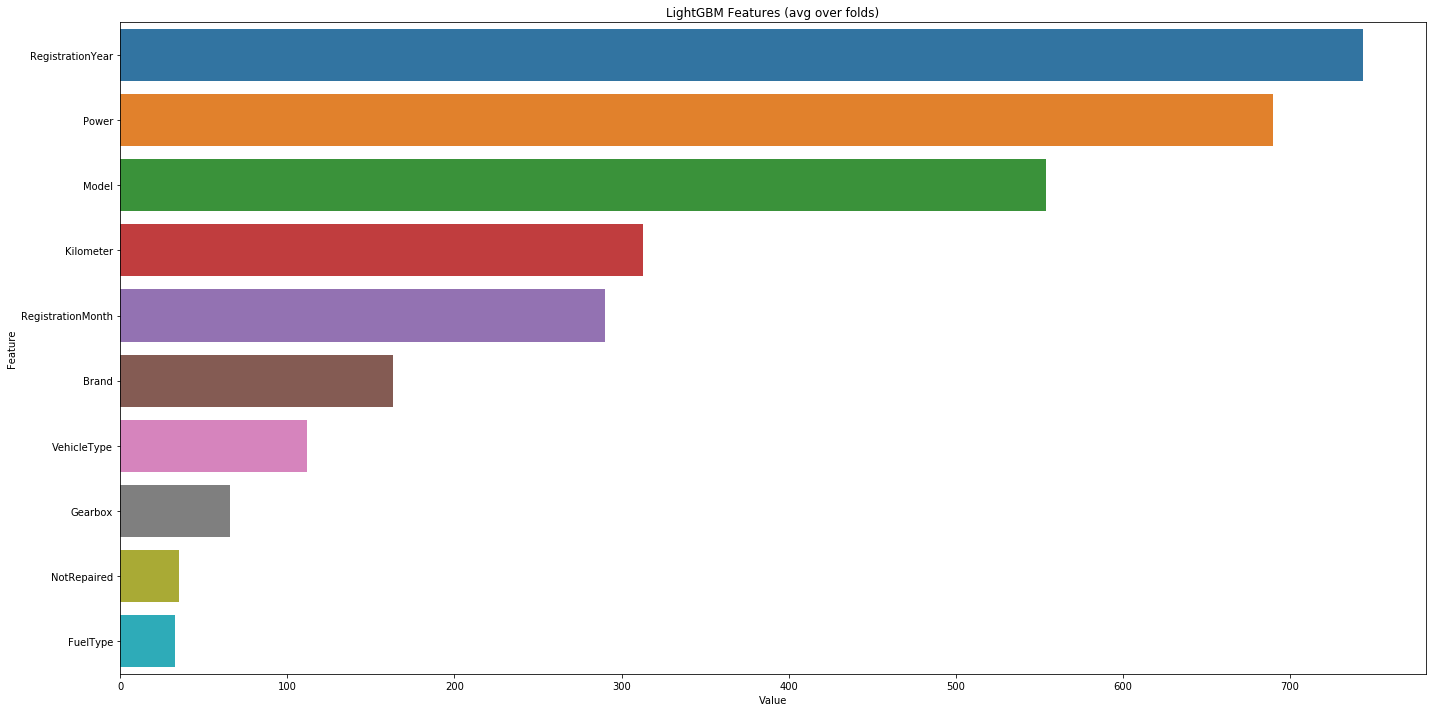

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

**Как видно из полученных данных:**

- Лучший RMSE из коробки показывает LightGBM 1749, но по времени обучение проходит 14.8 сек
- Лучшее время из коробки показал LinearRegression ~ 0.08 секунд, но с результатов RMSE 3325
- CatBoost же показал RMSE 1783, а время обучения 626 сек.

После тюнинга моделей получили такие вот результаты:

- Лучший результат RMSE у CatBoost 1701 на тестовой выборке со временем обучения 639 секунд.
- У LightGBM результат 1751 о временем обучения 11 секунд.
- LinearRegression - RMSE 3325, так как параметров у него особо нет.

**Вывод:**
- Все модели градиентного бустинга(catboost, lightgbm) из коробки показывают относительно хорошие результаты, чего не скажешь про линейную регрессию. Время обучения у всех разное от 600 сек до 0.07 секунд.
- После тюнинга моделей лучший результат показал Catboost 1701 на тестовой выборке. Скорость обучения составила 628 секунд.
- LightGBM - показал неплохие результаты относительно своей скорости 1751 за 6 секунд.

**Скорость предсказания**
- Скорость предсказания у моделей так же разная:
 - Catboost без тюнинга : 0.7 сек
 - LightGBM без тюнинга : 1.2 сек
 - LinearRegression без тюнинга : 0.07 сек.
 - CatBoost с тюнингом : 1.6 сек
 - LightGBM с тюнингом : 0.7 сек
 - LinearRegression с тюнингом : 0.004 сек
 
Определенно градиентный бустинг показывает лучшие результаты нежели просто Линейная регрессия. Поэтому исходя их полученных результатов можем сказать, что по данному датасету лучшей моделью оказался LightGBM как скорость и результат.